In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import minmax_scale
import random
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
TARGET_SIZE = 224

train_datagen = ImageDataGenerator(rescale=1./255.,
                                     featurewise_center=True,
                                       zoom_range = 0.07,
                                     validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale= 1./255)

train_data = train_datagen.flow_from_directory(
    'data/COVID-19 Radiography Database/Train',
    class_mode="sparse",
    batch_size=32,
    target_size=(TARGET_SIZE,TARGET_SIZE),
    shuffle=True,
    subset="training",
)

validation_data = train_datagen.flow_from_directory(
    'data/COVID-19 Radiography Database/Train',
    class_mode="sparse",
    batch_size=32,
    target_size=(TARGET_SIZE, TARGET_SIZE),
    shuffle=True,
    subset="validation",
)

test_data = test_datagen.flow_from_directory(
    'data/COVID-19 Radiography Database/Test',
    class_mode="sparse",
    batch_size=32,
    target_size=(TARGET_SIZE, TARGET_SIZE),
    shuffle=False,
)

Found 3218 images belonging to 3 classes.
Found 356 images belonging to 3 classes.
Found 312 images belonging to 3 classes.


In [3]:
base_model = tf.keras.applications.ResNet152V2(weights="imagenet",include_top=False,input_shape=(TARGET_SIZE,TARGET_SIZE, 3))

for layer in base_model.layers[:300]:
    layer.trainable = False

for layer in base_model.layers[300:]:
    layer.trainable = True
    
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

predictions = Dense(3, activation='softmax')(x)



model=Sequential()
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),metrics=['accuracy'])
model.summary()
model_save = ModelCheckpoint('weights.h5', 
                              save_best_only = True, 
                              save_weights_only = True,
                              monitor = 'val_loss', 
                              mode = 'min', verbose = 1)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [4]:
EPOCHS = 10
history = model.fit_generator(
     train_data,
     steps_per_epoch=train_data.samples//train_data.batch_size,
     epochs = EPOCHS,
     validation_data = validation_data,
     validation_steps=validation_data.samples//validation_data.batch_size,
     callbacks = [model_save])

Epoch 1/10
100/100 [==============================] - 180s 2s/step - loss: 1.1304 - accuracy: 0.4712 - val_loss: 326448.2188 - val_accuracy: 0.3494

Epoch 00001: val_loss improved from inf to 326448.21875, saving model to weights.h5
Epoch 2/10
100/100 [==============================] - 145s 1s/step - loss: 0.5493 - accuracy: 0.7720 - val_loss: 77.7487 - val_accuracy: 0.4631

Epoch 00002: val_loss improved from 326448.21875 to 77.74873, saving model to weights.h5
Epoch 3/10
100/100 [==============================] - 123s 1s/step - loss: 0.3880 - accuracy: 0.8610 - val_loss: 27.3683 - val_accuracy: 0.7188

Epoch 00003: val_loss improved from 77.74873 to 27.36835, saving model to weights.h5
Epoch 4/10
100/100 [==============================] - 126s 1s/step - loss: 0.3004 - accuracy: 0.9109 - val_loss: 0.9960 - val_accuracy: 0.6705

Epoch 00004: val_loss improved from 27.36835 to 0.99605, saving model to weights.h5
Epoch 5/10
100/100 [==============================] - 116s 1s/step - loss: 

In [5]:
pred = model.predict_generator(test_data)
y_pred = pred.argmax(axis=-1)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 2 1 2 2 1 2 1 1 2 1 1 1 1 1 1 2 1 1 1 1 2 2 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 2 1 1 2 1 2 1 2 1 1 2 2 2 1 1 1 2 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1
 1 2 1 1 1 1 1 1 2 2 1 2 1 1 1 2 2 1 1 2 2 1 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [6]:
model.evaluate(test_data)

10/10 [==============================] - 6s 547ms/step - loss: 0.2600 - accuracy: 0.8942


[0.2599840462207794, 0.8942307829856873]

In [7]:
model.save('resnet101.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


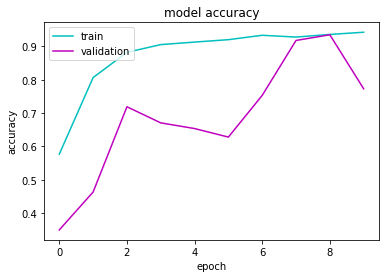

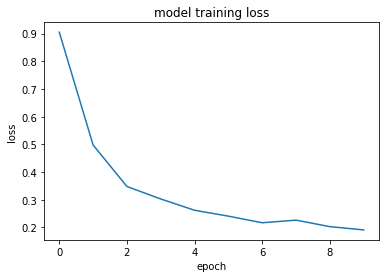

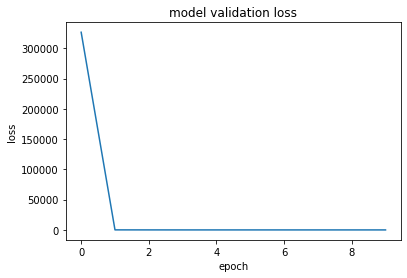

In [8]:
print(history.history.keys())
plt.plot(history.history['accuracy'],color='c')
plt.plot(history.history['val_accuracy'],color='m')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('model training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['val_loss'])
plt.title('model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Confusion Matrix
[[104   0   0]
 [  0  76  28]
 [  5   0  99]]
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.95413   1.00000   0.97653       104
           1    1.00000   0.73077   0.84444       104
           2    0.77953   0.95192   0.85714       104

    accuracy                        0.89423       312
   macro avg    0.91122   0.89423   0.89270       312
weighted avg    0.91122   0.89423   0.89270       312



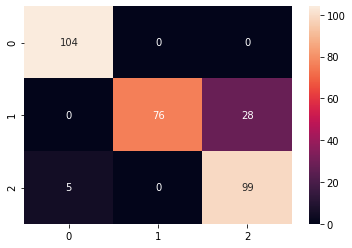

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(test_data.classes, y_pred)
print(cm)
print(sns.heatmap(confusion_matrix(test_data.classes, y_pred),annot=True,fmt="d"))
print(classification_report(test_data.classes, y_pred, digits=5))


In [10]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print(np.mean(recall))
print(np.mean(precision))

0.8910256410256411
0.9125488357555868
